### Experimento 3
### IPN- CIC
### Alumno: Jorge Diego García Torres
#### Titulo : Clasificación de los grados de retinopatía diabética en imágenes del fondo del ojo mediante algoritmos de aprendizaje profundo.
#### Ensamble IDRiD

In [1]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold

import os
import sys
import cv2
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Input


def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed = 0
seed_everything(seed)


sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
dftrain = pd.read_csv('/content/gdrive/My Drive/tesis/idrid/a. IDRiD_Disease Grading_Training Labels.csv')
dftest = pd.read_csv('/content/gdrive/My Drive/tesis/idrid/b. IDRiD_Disease Grading_Testing Labels.csv')
x_train = np.load('/content/gdrive/My Drive/tesis/idrid/idrid224.npy')
x_test1 = np.load('/content/gdrive/My Drive/tesis/idrid/testidrid224.npy')
y_test1 = pd.get_dummies(dftest['Retinopathy grade']).values

y_train = pd.get_dummies(dftrain['Retinopathy grade']).values

train = pd.read_csv('/content/gdrive/My Drive/tesis2/exp3idrid_5-fold.csv')

X_train = train[train['fold_0'] == 'train']
X_val = train[train['fold_0'] == 'validation']

x_train_i = X_train['index'].values
x_val_i = X_val['index'].values

In [6]:
x_train1 = np.empty((330,224,224,3),dtype='uint8')
x_val1 = np.empty((83,224,224,3),dtype='uint8')

y_train1 =  np.empty((330,5),dtype='uint8')
y_val1 = np.empty((83,5),dtype='uint8')

for i in range(len(x_train_i)):
  x_train1[i] = x_train[x_train_i[i]]
  y_train1[i] = y_train[x_train_i[i]]

for j in range(len(x_val_i)):
  x_val1[j] = x_train[x_val_i[j]]
  y_val1[j] = y_train[x_val_i[j]]

In [7]:
print(x_train1.shape)
print(x_val1.shape)
print(y_train1.shape)
print(y_val1.shape)

(330, 224, 224, 3)
(83, 224, 224, 3)
(330, 5)
(83, 5)


In [41]:
x_test1.shape

(103, 224, 224, 3)

In [8]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
#from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tqdm import tqdm

In [9]:
weights_path_list = ['/content/gdrive/My Drive/tesismodelos/exp3idridfinalefffold0.h5', '/content/gdrive/My Drive/tesismodelos/exp3idridfinalefffold1.h5',
                     '/content/gdrive/My Drive/tesismodelos/exp3idridfinalefffold2.h5', '/content/gdrive/My Drive/tesismodelos/exp3idridfinalefffold3.h5',
                     '/content/gdrive/My Drive/tesismodelos/exp3idridfinalefffold4.h5']

In [10]:
def ensemble_preds(model_list, generator):
    preds_ensemble = []
    for model in model_list:
        generator.reset()
        preds = model.predict(generator, verbose = 1)
        preds_ensemble.append(preds)
        generator.reset()

    return np.mean(preds_ensemble, axis=0)


def apply_tta(model, generator, steps=5):
    step_size = generator.n//generator.batch_size
    preds_tta = []
    for i in range(steps):
        generator.reset()
        preds = model.predict_generator(generator, steps=step_size)
        preds_tta.append(preds)

    return np.mean(preds_tta, axis=0)

def test_ensemble_preds(model_list, generator, steps=5):
    preds_ensemble = []
    for model in model_list:
        preds = apply_tta(model, generator, steps)
        preds_ensemble.append(preds)

    return np.mean(preds_ensemble, axis=0)


In [11]:
BATCH_SIZE = 8

train_datagen = ImageDataGenerator(rescale=1./ 255.,
                                   rotation_range=360,                               
                                   #shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   vertical_flip=True)

val_datagen = ImageDataGenerator(rescale=1./ 255.,
                                   rotation_range=360,                               
                                   #shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./ 255.,
                                   rotation_range=360,                               
                                   #shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   vertical_flip=True)


In [12]:
data_generator = train_datagen.flow(x_train1, y_train1, batch_size=1, seed=2020)
vdata_gen =  val_datagen.flow(x_val1, y_val1, batch_size=1, seed=2020)
tdata_gen =  test_datagen.flow(x_test1, y_test1, batch_size=1, seed=2020)

In [13]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras import applications
from keras import optimizers,Model,Sequential

In [14]:
pip install -U efficientnet

     |████████████████████████████████| 51kB 4.7MB/s 


In [15]:
import efficientnet.keras as efn 

In [16]:
def create_model(input_shape, n_out, weights_path):
    input_tensor = Input(shape=input_shape)
    base_model = efn.EfficientNetB5(weights=None,include_top=False,input_tensor=input_tensor)
    #base_model = applications.ResNet50(weights='imagenet', include_top=False,input_tensor=input_tensor)
    #base_model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)

    model.load_weights(weights_path)
    return model

In [17]:
model_list = []

for weights_path in weights_path_list:
  model_list.append(create_model(input_shape=(224, 224, 3), n_out=5, weights_path= weights_path))

In [18]:
vdata_gen.reset()

x_vdata = np.zeros((83,224, 224, 3))
y_val2 = np.array([[0,0,0,0,0]])

for i in range(83):
  y_val2 =np.append(y_val2, vdata_gen[i][1], axis=0)
  x_vdata[i]= vdata_gen[i][0]

y_val2 = np.delete(y_val2,0, axis=0)

vdata_gen.reset()

In [ ]:
val_gen1 = [np.argmax(pred) for pred in y_val2]
val_gen1

In [20]:
preds_ensemble = []

In [34]:
x_vdata.shape

(83, 224, 224, 3)

In [21]:
val_preds_model1 = model_list[0].predict(x_vdata, verbose = 1)
preds_ensemble.append(val_preds_model1)
val_preds_model1 = [np.argmax(pred) for pred in val_preds_model1]


3/3 [==============================] - 0s 106ms/step


In [22]:
print("Val Cohen Kappa score: %.3f" % cohen_kappa_score(val_preds_model1, val_gen1, weights='quadratic'))

Val Cohen Kappa score: 0.879


In [23]:
val_preds_model2 = model_list[1].predict(x_vdata, verbose = 1)
preds_ensemble.append(val_preds_model2)
val_preds_model2 = [np.argmax(pred) for pred in val_preds_model2]

3/3 [==============================] - 0s 56ms/step


In [24]:
print("Val Cohen Kappa score: %.3f" % cohen_kappa_score(val_preds_model2, val_gen1, weights='quadratic'))

Val Cohen Kappa score: 0.865


In [25]:
val_preds_model3 = model_list[2].predict(x_vdata, verbose = 1)
preds_ensemble.append(val_preds_model3)
val_preds_model3 = [np.argmax(pred) for pred in val_preds_model3]

3/3 [==============================] - 0s 56ms/step


In [26]:
print("Val Cohen Kappa score: %.3f" % cohen_kappa_score(val_preds_model3, val_gen1, weights='quadratic'))

Val Cohen Kappa score: 0.924


In [27]:
val_preds_model4 = model_list[3].predict(x_vdata, verbose = 1)
preds_ensemble.append(val_preds_model4)
val_preds_model4 = [np.argmax(pred) for pred in val_preds_model4]

3/3 [==============================] - 0s 57ms/step


In [28]:
print("Val Cohen Kappa score: %.3f" % cohen_kappa_score(val_preds_model4, val_gen1, weights='quadratic'))

Val Cohen Kappa score: 0.975


In [29]:
val_preds_model5 = model_list[4].predict(x_vdata, verbose = 1)
preds_ensemble.append(val_preds_model5)
val_preds_model5 = [np.argmax(pred) for pred in val_preds_model5]

3/3 [==============================] - 0s 55ms/step


In [30]:
print("Val Cohen Kappa score: %.3f" % cohen_kappa_score(val_preds_model5, val_gen1, weights='quadratic'))

Val Cohen Kappa score: 0.932


In [31]:
preds_ensemble =  np.mean(preds_ensemble, axis=0)
preds_ensemble = [np.argmax(pred) for pred in preds_ensemble]

In [32]:
print("Val Cohen Kappa score: %.3f" % cohen_kappa_score(preds_ensemble, val_gen1, weights='quadratic'))

Val Cohen Kappa score: 0.953


In [35]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

In [36]:
import seaborn as sns

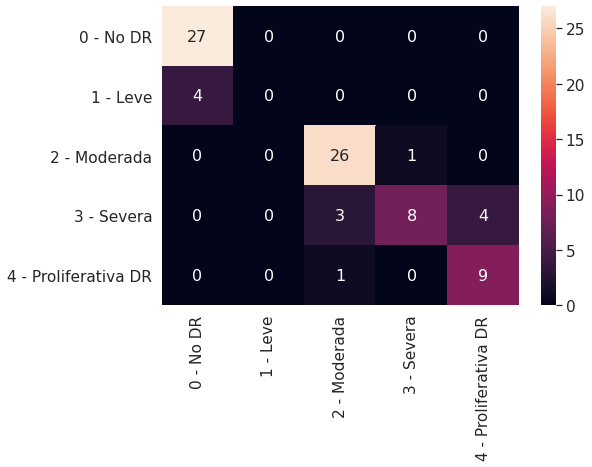

In [37]:
labels = ['0 - No DR', '1 - Leve', '2 - Moderada', '3 - Severa', '4 - Proliferativa DR']
plot_conf_matrix(val_gen1,preds_ensemble,labels)

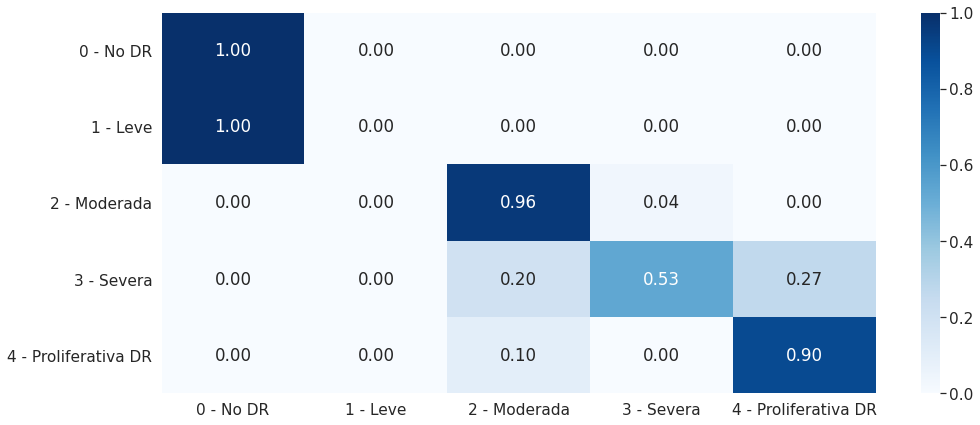

In [38]:
cnf_matrix = confusion_matrix(val_gen1, preds_ensemble)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [39]:
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report

In [40]:
print("Val Cohen Kappa score: %.3f" % cohen_kappa_score(val_gen1, preds_ensemble, weights='quadratic'))
print("Val Accuracy score : %.3f" % accuracy_score(val_gen1, preds_ensemble))

print('F1 score: %.3f' % f1_score(val_gen1, preds_ensemble,average='micro'))
print('F1 score: %.3f' % f1_score(val_gen1, preds_ensemble,average='weighted'))
print('F1 score: %.3f' % f1_score(val_gen1, preds_ensemble,average='macro'))


print('Recall: %.3f' % recall_score(val_gen1, preds_ensemble,average='micro'))
print('Recall: %.3f' % recall_score(val_gen1, preds_ensemble,average='weighted'))
print('Recall: %.3f' % recall_score(val_gen1, preds_ensemble,average='macro'))

print('Precision: %.3f' % precision_score(val_gen1, preds_ensemble,average='micro'))
print('Precision: %.3f' % precision_score(val_gen1, preds_ensemble,average='weighted'))
print('Precision: %.3f' % precision_score(val_gen1, preds_ensemble,average='macro'))

print('\n clasification report:\n  ' + classification_report(val_gen1, preds_ensemble)) 

Val Cohen Kappa score: 0.953
Val Accuracy score : 0.843
F1 score: 0.843
F1 score: 0.814
F1 score: 0.659
Recall: 0.843
Recall: 0.843
Recall: 0.679
Precision: 0.843
Precision: 0.809
Precision: 0.664

 clasification report:
                precision    recall  f1-score   support

           0       0.87      1.00      0.93        27
           1       0.00      0.00      0.00         4
           2       0.87      0.96      0.91        27
           3       0.89      0.53      0.67        15
           4       0.69      0.90      0.78        10

    accuracy                           0.84        83
   macro avg       0.66      0.68      0.66        83
weighted avg       0.81      0.84      0.81        83



test data sin TTA

In [42]:
tdata_gen.reset()

x_tdata = np.zeros((103,224, 224, 3))
y_test2 = np.array([[0,0,0,0,0]])

for i in range(103):
  y_test2 =np.append(y_test2, tdata_gen[i][1], axis=0)
  x_tdata[i]= tdata_gen[i][0]

y_test2 = np.delete(y_test2,0, axis=0)

tdata_gen.reset()

In [43]:
tpreds_ensemble = []

[0 0 0 0 1]


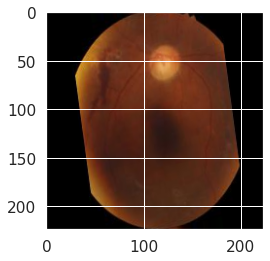

In [54]:
plt.imshow(x_tdata[4])
print(y_test2[4])

In [44]:
test_preds_model1 = model_list[0].predict(x_tdata, verbose = 1)
tpreds_ensemble.append(test_preds_model1)
test_preds_model1 = [np.argmax(pred) for pred in test_preds_model1]

4/4 [==============================] - 0s 96ms/step


In [45]:
test_gen1 = [np.argmax(pred) for pred in y_test2]

In [46]:
print("test Cohen Kappa score: %.3f" % cohen_kappa_score(test_preds_model1, test_gen1, weights='quadratic'))

test Cohen Kappa score: 0.729


In [47]:
test_preds_model2 = model_list[1].predict(x_tdata, verbose = 1)
tpreds_ensemble.append(test_preds_model2)
test_preds_model2 = [np.argmax(pred) for pred in test_preds_model2]

4/4 [==============================] - 0s 54ms/step


In [48]:
print("test Cohen Kappa score: %.3f" % cohen_kappa_score(test_preds_model2, test_gen1, weights='quadratic'))

test Cohen Kappa score: 0.740


In [55]:
test_preds_model3 = model_list[2].predict(x_tdata, verbose = 1)
tpreds_ensemble.append(test_preds_model3)
test_preds_model3 = [np.argmax(pred) for pred in test_preds_model3]

4/4 [==============================] - 0s 55ms/step


In [56]:
print("test Cohen Kappa score: %.3f" % cohen_kappa_score(test_preds_model3, test_gen1, weights='quadratic'))

test Cohen Kappa score: 0.754


In [57]:
test_preds_model4 = model_list[3].predict(x_tdata, verbose = 1)
tpreds_ensemble.append(test_preds_model4)
test_preds_model4 = [np.argmax(pred) for pred in test_preds_model4]

4/4 [==============================] - 0s 56ms/step


In [58]:
print("test Cohen Kappa score: %.3f" % cohen_kappa_score(test_preds_model4, test_gen1, weights='quadratic'))

test Cohen Kappa score: 0.689


In [59]:
test_preds_model5 = model_list[4].predict(x_tdata, verbose = 1)
tpreds_ensemble.append(test_preds_model5)
test_preds_model5 = [np.argmax(pred) for pred in test_preds_model5]

4/4 [==============================] - 0s 56ms/step


In [60]:
print("test Cohen Kappa score: %.3f" % cohen_kappa_score(test_preds_model5, test_gen1, weights='quadratic'))

test Cohen Kappa score: 0.727


In [61]:
tpreds_ensemble =  np.mean(tpreds_ensemble, axis=0)
tpreds_ensemble = [np.argmax(pred) for pred in tpreds_ensemble]

In [62]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(tpreds_ensemble, test_gen1, weights='quadratic'))

Test Cohen Kappa score: 0.740


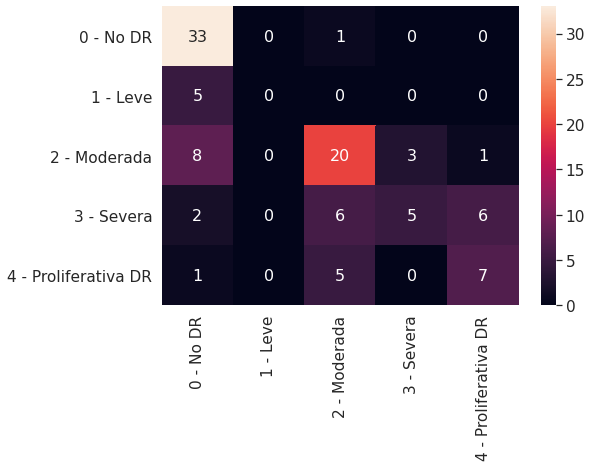

In [63]:
labels = ['0 - No DR', '1 - Leve', '2 - Moderada', '3 - Severa', '4 - Proliferativa DR']
plot_conf_matrix(test_gen1,tpreds_ensemble,labels)

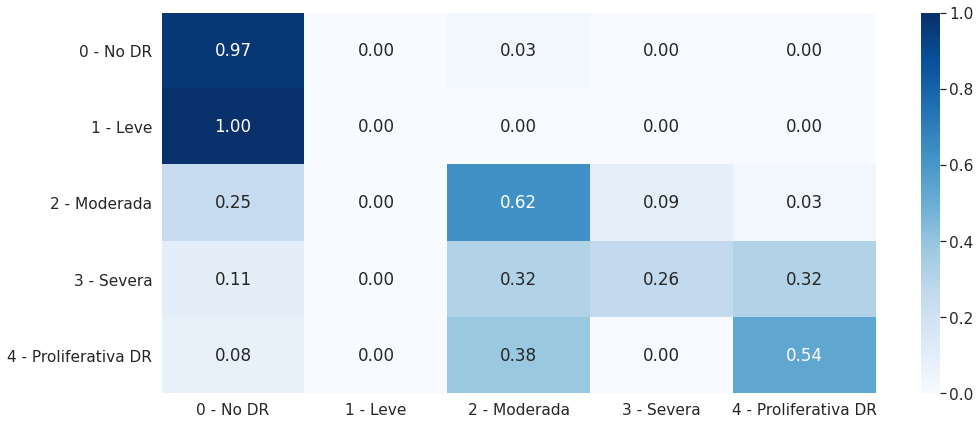

In [64]:
cnf_matrix = confusion_matrix(test_gen1, tpreds_ensemble)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [65]:
cf = cnf_matrix

In [66]:
FP = cf.sum(axis=0) - np.diag(cf)  
FN = cf.sum(axis=1) - np.diag(cf)
TP = np.diag(cf)
TN = cf.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('FP')
print(FP)
print('FN')
print(FN)
print('TP')
print(TP)
print('TN')
print(TN)
print('Sensitivity')
print(TPR)
print('Specificity')
print(TNR)
print('Precision')
print(PPV)
print(NPV)
print(FPR)
print(FNR)
print(FDR)
print('Acc')
print(ACC)

print('Sensitivity mean')
print(np.mean(TPR))
print('Specificity mean')
print(np.mean(TNR))
print('Precision mean')
print(np.mean(PPV))


FP
[16  0 12  3  7]
FN
[ 1  5 12 14  6]
TP
[33  0 20  5  7]
TN
[53 98 59 81 83]
Sensitivity
[0.97058824 0.         0.625      0.26315789 0.53846154]
Specificity
[0.76811594 1.         0.83098592 0.96428571 0.92222222]
Precision
[0.67346939        nan 0.625      0.625      0.5       ]
[0.98148148 0.95145631 0.83098592 0.85263158 0.93258427]
[0.23188406 0.         0.16901408 0.03571429 0.07777778]
[0.02941176 1.         0.375      0.73684211 0.46153846]
[0.32653061        nan 0.375      0.375      0.5       ]
Acc
[0.83495146 0.95145631 0.76699029 0.83495146 0.87378641]
Sensitivity mean
0.4794415336984996
Specificity mean
0.897121958805976
Precision mean
nan


In [67]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_gen1, tpreds_ensemble, weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(test_gen1, tpreds_ensemble))

print('F1 score: %.3f' % f1_score(test_gen1, tpreds_ensemble,average='micro'))
print('F1 score: %.3f' % f1_score(test_gen1, tpreds_ensemble,average='weighted'))
print('F1 score: %.3f' % f1_score(test_gen1, tpreds_ensemble,average='macro'))

print('Recall: %.3f' % recall_score(test_gen1, tpreds_ensemble,average='micro'))
print('Recall: %.3f' % recall_score(test_gen1, tpreds_ensemble,average='weighted'))
print('Recall: %.3f' % recall_score(test_gen1, tpreds_ensemble,average='macro'))

print('Precision: %.3f' % precision_score(test_gen1, tpreds_ensemble,average='micro'))
print('Precision: %.3f' % precision_score(test_gen1, tpreds_ensemble,average='weighted'))
print('Precision: %.3f' % precision_score(test_gen1, tpreds_ensemble,average='macro'))

print('\n clasification report:\n  ' + classification_report(test_gen1, tpreds_ensemble)) 

Test Cohen Kappa score: 0.740
Test Accuracy score : 0.631
F1 score: 0.631
F1 score: 0.590
F1 score: 0.462
Recall: 0.631
Recall: 0.631
Recall: 0.479
Precision: 0.631
Precision: 0.595
Precision: 0.485

 clasification report:
                precision    recall  f1-score   support

           0       0.67      0.97      0.80        34
           1       0.00      0.00      0.00         5
           2       0.62      0.62      0.62        32
           3       0.62      0.26      0.37        19
           4       0.50      0.54      0.52        13

    accuracy                           0.63       103
   macro avg       0.48      0.48      0.46       103
weighted avg       0.59      0.63      0.59       103



In [68]:
from scipy import stats

In [ ]:
#stats.trim_mean()

trim mean


In [81]:
tdata_gen.reset()

x_tdata = np.zeros((103,224, 224, 3))
y_test2 = np.array([[0,0,0,0,0]])

for i in range(103):
  y_test2 =np.append(y_test2, tdata_gen[i][1], axis=0)
  x_tdata[i]= tdata_gen[i][0]

y_test2 = np.delete(y_test2,0, axis=0)

tdata_gen.reset()

In [82]:
test_gen1 = [np.argmax(pred) for pred in y_test2]

In [83]:
tpreds_ensemble = []

In [84]:
test_preds_model1 = model_list[0].predict(x_tdata, verbose = 1)
tpreds_ensemble.append(test_preds_model1)
test_preds_model1 = [np.argmax(pred) for pred in test_preds_model1]
print("test Cohen Kappa score: %.3f" % cohen_kappa_score(test_preds_model1, test_gen1, weights='quadratic'))

4/4 [==============================] - 0s 55ms/step
test Cohen Kappa score: 0.742


In [85]:
test_preds_model2 = model_list[1].predict(x_tdata, verbose = 1)
tpreds_ensemble.append(test_preds_model2)
test_preds_model2 = [np.argmax(pred) for pred in test_preds_model2]
print("test Cohen Kappa score: %.3f" % cohen_kappa_score(test_preds_model2, test_gen1, weights='quadratic'))

4/4 [==============================] - 0s 53ms/step
test Cohen Kappa score: 0.745


In [86]:
test_preds_model3 = model_list[2].predict(x_tdata, verbose = 1)
tpreds_ensemble.append(test_preds_model3)
test_preds_model3 = [np.argmax(pred) for pred in test_preds_model3]
print("test Cohen Kappa score: %.3f" % cohen_kappa_score(test_preds_model3, test_gen1, weights='quadratic'))

4/4 [==============================] - 0s 52ms/step
test Cohen Kappa score: 0.699


In [87]:
test_preds_model4 = model_list[3].predict(x_tdata, verbose = 1)
tpreds_ensemble.append(test_preds_model4)
test_preds_model4 = [np.argmax(pred) for pred in test_preds_model4]
print("test Cohen Kappa score: %.3f" % cohen_kappa_score(test_preds_model4, test_gen1, weights='quadratic'))

4/4 [==============================] - 0s 52ms/step
test Cohen Kappa score: 0.708


In [88]:
test_preds_model5 = model_list[4].predict(x_tdata, verbose = 1)
tpreds_ensemble.append(test_preds_model5)
test_preds_model5 = [np.argmax(pred) for pred in test_preds_model5]
print("test Cohen Kappa score: %.3f" % cohen_kappa_score(test_preds_model5, test_gen1, weights='quadratic'))

4/4 [==============================] - 0s 52ms/step
test Cohen Kappa score: 0.775


In [89]:
t1preds_ensemble =  stats.trim_mean(tpreds_ensemble,.25, axis=0)
t1preds_ensemble = [np.argmax(pred) for pred in t1preds_ensemble]

In [90]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(t1preds_ensemble, test_gen1, weights='quadratic'))

Test Cohen Kappa score: 0.708


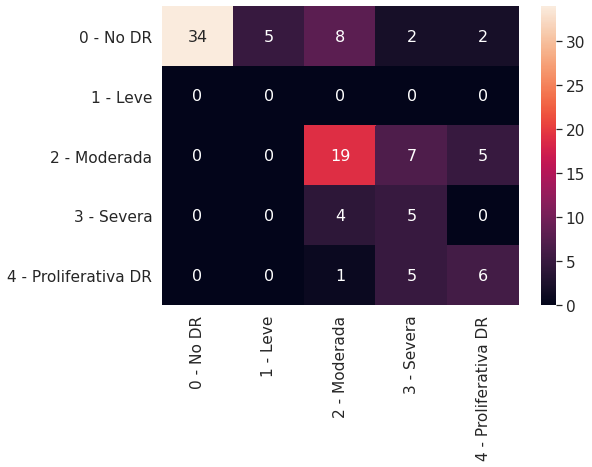

In [91]:
labels = ['0 - No DR', '1 - Leve', '2 - Moderada', '3 - Severa', '4 - Proliferativa DR']
plot_conf_matrix(t1preds_ensemble,test_gen1,labels)

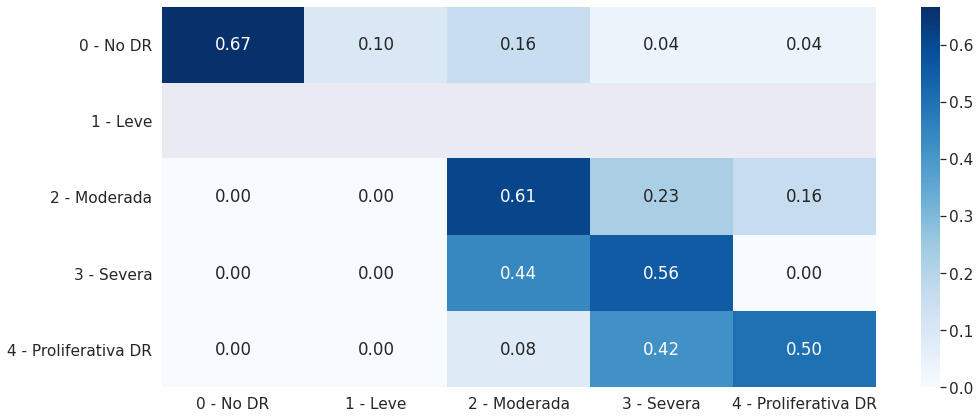

In [92]:
cnf_matrix = confusion_matrix(t1preds_ensemble, test_gen1)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [93]:
cf = cnf_matrix

In [94]:
FP = cf.sum(axis=0) - np.diag(cf)  
FN = cf.sum(axis=1) - np.diag(cf)
TP = np.diag(cf)
TN = cf.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('FP')
print(FP)
print('FN')
print(FN)
print('TP')
print(TP)
print('TN')
print(TN)
print('Sensitivity')
print(TPR)
print('Specificity')
print(TNR)
print('Precision')
print(PPV)
print(NPV)
print(FPR)
print(FNR)
print(FDR)
print('Acc')
print(ACC)

print('Sensitivity mean')
print(np.mean(TPR))
print('Specificity mean')
print(np.mean(TNR))
print('Precision mean')
print(np.mean(PPV))


FP
[ 0  5 13 14  7]
FN
[17  0 12  4  6]
TP
[34  0 19  5  6]
TN
[52 98 59 80 84]
Sensitivity
[0.66666667        nan 0.61290323 0.55555556 0.5       ]
Specificity
[1.         0.95145631 0.81944444 0.85106383 0.92307692]
Precision
[1.         0.         0.59375    0.26315789 0.46153846]
[0.75362319 1.         0.83098592 0.95238095 0.93333333]
[0.         0.04854369 0.18055556 0.14893617 0.07692308]
[0.33333333        nan 0.38709677 0.44444444 0.5       ]
[0.         1.         0.40625    0.73684211 0.53846154]
Acc
[0.83495146 0.95145631 0.75728155 0.82524272 0.87378641]
Sensitivity mean
nan
Specificity mean
0.9090083015976426
Precision mean
0.46368927125506076


In [95]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_gen1, t1preds_ensemble, weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(test_gen1, t1preds_ensemble))

print('F1 score: %.3f' % f1_score(test_gen1, t1preds_ensemble,average='micro'))
print('F1 score: %.3f' % f1_score(test_gen1, t1preds_ensemble,average='weighted'))
print('F1 score: %.3f' % f1_score(test_gen1, t1preds_ensemble,average='macro'))

print('Recall: %.3f' % recall_score(test_gen1, t1preds_ensemble,average='micro'))
print('Recall: %.3f' % recall_score(test_gen1, t1preds_ensemble,average='weighted'))
print('Recall: %.3f' % recall_score(test_gen1, t1preds_ensemble,average='macro'))

print('Precision: %.3f' % precision_score(test_gen1, t1preds_ensemble,average='micro'))
print('Precision: %.3f' % precision_score(test_gen1, t1preds_ensemble,average='weighted'))
print('Precision: %.3f' % precision_score(test_gen1, t1preds_ensemble,average='macro'))

print('\n clasification report:\n  ' + classification_report(test_gen1, t1preds_ensemble))

Test Cohen Kappa score: 0.708
Test Accuracy score : 0.621
F1 score: 0.621
F1 score: 0.578
F1 score: 0.448
Recall: 0.621
Recall: 0.621
Recall: 0.464
Precision: 0.621
Precision: 0.576
Precision: 0.467

 clasification report:
                precision    recall  f1-score   support

           0       0.67      1.00      0.80        34
           1       0.00      0.00      0.00         5
           2       0.61      0.59      0.60        32
           3       0.56      0.26      0.36        19
           4       0.50      0.46      0.48        13

    accuracy                           0.62       103
   macro avg       0.47      0.46      0.45       103
weighted avg       0.58      0.62      0.58       103



TTA

In [96]:
def apply_tta(model, generator, steps=5):
    step_size = generator.n//generator.batch_size
    preds_tta = []
    for i in range(steps):
        generator.reset()
        preds = model.predict_generator(generator, steps=step_size, verbose= 1)
        preds_tta.append(preds)

    return np.mean(preds_tta, axis=0)

In [97]:
def test_ensemble_preds(model_list, generator, steps=5):
    preds_ensemble = []
    for model in model_list:
        preds = apply_tta(model, generator, steps)
        preds_ensemble.append(preds)

    return np.mean(preds_ensemble, axis=0)

In [98]:
TTA_STEPS = 10

In [99]:
tdata_gen.reset()

x_tdata = np.zeros((103,224, 224, 3))
y_test2 = np.array([[0,0,0,0,0]])

for i in range(103):
  y_test2 =np.append(y_test2, tdata_gen[i][1], axis=0)
  x_tdata[i]= tdata_gen[i][0]

y_test2 = np.delete(y_test2,0, axis=0)

tdata_gen.reset()

In [100]:
tdata_gen.reset()

x_tdata1 = np.zeros((103,224, 224, 3))
y_test12 = np.array([[0,0,0,0,0]])

for i in range(103):
  y_test12 =np.append(y_test12, tdata_gen[i][1], axis=0)
  x_tdata1[i]= tdata_gen[i][0]

y_test12 = np.delete(y_test12,0, axis=0)

tdata_gen.reset()

In [101]:
tdata_gen.reset()

x_tdata2 = np.zeros((103,224, 224, 3))
y_test22 = np.array([[0,0,0,0,0]])

for i in range(103):
  y_test22 =np.append(y_test22, tdata_gen[i][1], axis=0)
  x_tdata2[i]= tdata_gen[i][0]

y_test22 = np.delete(y_test22,0, axis=0)

tdata_gen.reset()

In [102]:
tdata_gen.reset()

x_tdata3 = np.zeros((103,224, 224, 3))
y_test32 = np.array([[0,0,0,0,0]])

for i in range(103):
  y_test32 =np.append(y_test32, tdata_gen[i][1], axis=0)
  x_tdata3[i]= tdata_gen[i][0]

y_test32 = np.delete(y_test32,0, axis=0)

tdata_gen.reset()

In [103]:
tdata_gen.reset()

x_tdata4 = np.zeros((103,224, 224, 3))
y_test42 = np.array([[0,0,0,0,0]])

for i in range(103):
  y_test42 =np.append(y_test42, tdata_gen[i][1], axis=0)
  x_tdata4[i]= tdata_gen[i][0]

y_test42 = np.delete(y_test42,0, axis=0)

tdata_gen.reset()

In [104]:
tdata_gen.reset()

x_tdata5 = np.zeros((103,224, 224, 3))
y_test52 = np.array([[0,0,0,0,0]])

for i in range(103):
  y_test52 =np.append(y_test52, tdata_gen[i][1], axis=0)
  x_tdata5[i]= tdata_gen[i][0]

y_test52 = np.delete(y_test52,0, axis=0)

tdata_gen.reset()

In [105]:
preds_ensemble = []

In [106]:
preds_tta = []

In [107]:
test_preds_model1 = model_list[0].predict(x_tdata, verbose = 1)
preds_tta.append(test_preds_model1)

test_preds_model1 = model_list[0].predict(x_tdata1, verbose = 1)
preds_tta.append(test_preds_model1)

test_preds_model1 = model_list[0].predict(x_tdata2, verbose = 1)
preds_tta.append(test_preds_model1)

test_preds_model1 = model_list[0].predict(x_tdata3, verbose = 1)
preds_tta.append(test_preds_model1)

test_preds_model1 = model_list[0].predict(x_tdata4, verbose = 1)
preds_tta.append(test_preds_model1)

test_preds_model1 = model_list[0].predict(x_tdata5, verbose = 1)
preds_tta.append(test_preds_model1)

test_model1 = np.mean(preds_tta, axis=0)

4/4 [==============================] - 0s 52ms/step


In [108]:
preds_ensemble.append(test_model1)

In [109]:
preds_tta = []

In [110]:
test_preds_model2 = model_list[1].predict(x_tdata, verbose = 1)
preds_tta.append(test_preds_model2)

test_preds_model2 = model_list[1].predict(x_tdata1, verbose = 1)
preds_tta.append(test_preds_model2)

test_preds_model2 = model_list[1].predict(x_tdata2, verbose = 1)
preds_tta.append(test_preds_model2)

test_preds_model2 = model_list[1].predict(x_tdata3, verbose = 1)
preds_tta.append(test_preds_model2)

test_preds_model2 = model_list[1].predict(x_tdata4, verbose = 1)
preds_tta.append(test_preds_model2)

test_preds_model2 = model_list[1].predict(x_tdata5, verbose = 1)
preds_tta.append(test_preds_model2)

test_model2 = np.mean(preds_tta, axis=0)

4/4 [==============================] - 0s 52ms/step


In [111]:
preds_ensemble.append(test_model2)

In [112]:
preds_tta = []

In [113]:
test_preds_model3 = model_list[2].predict(x_tdata, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[2].predict(x_tdata1, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[2].predict(x_tdata2, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[2].predict(x_tdata3, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[2].predict(x_tdata4, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[2].predict(x_tdata5, verbose = 1)
preds_tta.append(test_preds_model3)

test_model3 = np.mean(preds_tta, axis=0)

4/4 [==============================] - 0s 52ms/step


In [114]:
preds_ensemble.append(test_model3)

In [115]:
preds_tta = []

In [116]:
test_preds_model3 = model_list[3].predict(x_tdata, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[3].predict(x_tdata1, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[3].predict(x_tdata2, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[3].predict(x_tdata3, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[3].predict(x_tdata4, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[3].predict(x_tdata5, verbose = 1)
preds_tta.append(test_preds_model3)

test_model4 = np.mean(preds_tta, axis=0)

4/4 [==============================] - 0s 52ms/step


In [117]:
preds_ensemble.append(test_model4)

In [118]:
preds_tta = []

In [119]:
test_preds_model3 = model_list[4].predict(x_tdata, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[4].predict(x_tdata1, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[4].predict(x_tdata2, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[4].predict(x_tdata3, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[4].predict(x_tdata4, verbose = 1)
preds_tta.append(test_preds_model3)

test_preds_model3 = model_list[4].predict(x_tdata5, verbose = 1)
preds_tta.append(test_preds_model3)

test_model5 = np.mean(preds_tta, axis=0)

4/4 [==============================] - 0s 52ms/step


In [120]:
preds_ensemble.append(test_model5)

In [121]:
preds_tta = []

In [122]:
ttapreds= np.mean(preds_ensemble, axis=0)

In [123]:
ttapreds1 = [np.argmax(pred) for pred in ttapreds]

In [124]:
c=y_test2 == y_test32
c.all()

True

In [125]:
y_test2tta = [np.argmax(pred) for pred in y_test2]

In [126]:
print("test Cohen Kappa score: %.3f" % cohen_kappa_score(ttapreds1, y_test2tta, weights='quadratic'))

test Cohen Kappa score: 0.713


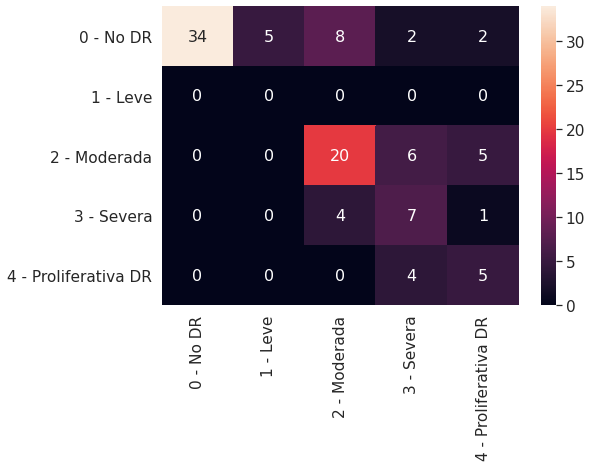

In [127]:
labels = ['0 - No DR', '1 - Leve', '2 - Moderada', '3 - Severa', '4 - Proliferativa DR']
plot_conf_matrix(ttapreds1,y_test2tta, labels)

In [128]:
cf = confusion_matrix(y_test2tta, ttapreds1)

In [129]:
FP = cf.sum(axis=0) - np.diag(cf)  
FN = cf.sum(axis=1) - np.diag(cf)
TP = np.diag(cf)
TN = cf.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('FP')
print(FP)
print('FN')
print(FN)
print('TP')
print(TP)
print('TN')
print(TN)
print('Sensitivity')
print(TPR)
print('Specificity')
print(TNR)
print('Precision')
print(PPV)
print(NPV)
print(FPR)
print(FNR)
print(FDR)
print('Acc')
print(ACC)

print('Sensitivity mean')
print(np.mean(TPR))
print('Specificity mean')
print(np.mean(TNR))
print('Precision mean')
print(np.mean(PPV))


FP
[17  0 11  5  4]
FN
[ 0  5 12 12  8]
TP
[34  0 20  7  5]
TN
[52 98 60 79 86]
Sensitivity
[1.         0.         0.625      0.36842105 0.38461538]
Specificity
[0.75362319 1.         0.84507042 0.94047619 0.95555556]
Precision
[0.66666667        nan 0.64516129 0.58333333 0.55555556]
[1.         0.95145631 0.83333333 0.86813187 0.91489362]
[0.24637681 0.         0.15492958 0.05952381 0.04444444]
[0.         1.         0.375      0.63157895 0.61538462]
[0.33333333        nan 0.35483871 0.41666667 0.44444444]
Acc
[0.83495146 0.95145631 0.77669903 0.83495146 0.88349515]
Sensitivity mean
0.47560728744939273
Specificity mean
0.8989450713945508
Precision mean
nan


In [130]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(ttapreds1, y_test2tta, weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(ttapreds1, y_test2tta))

print('F1 score: %.3f' % f1_score(ttapreds1, y_test2tta,average='micro'))
print('F1 score: %.3f' % f1_score(ttapreds1, y_test2tta,average='weighted'))
print('F1 score: %.3f' % f1_score(y_test2tta,ttapreds1,average='macro'))

print('Recall: %.3f' % recall_score(ttapreds1, y_test2tta,average='micro'))
print('Recall: %.3f' % recall_score(ttapreds1, y_test2tta,average='weighted'))
print('Recall: %.3f' % recall_score(y_test2tta,ttapreds1,average='macro'))

print('Precision: %.3f' % precision_score(ttapreds1, y_test2tta,average='micro'))
print('Precision: %.3f' % precision_score(ttapreds1, y_test2tta,average='weighted'))
print('Precision: %.3f' % precision_score(y_test2tta,ttapreds1,average='macro'))

print('\n clasification report:\n  ' + classification_report(ttapreds1, y_test2tta))

Test Cohen Kappa score: 0.713
Test Accuracy score : 0.641
F1 score: 0.641
F1 score: 0.680
F1 score: 0.468
Recall: 0.641
Recall: 0.641
Recall: 0.476
Precision: 0.641
Precision: 0.760
Precision: 0.490

 clasification report:
                precision    recall  f1-score   support

           0       1.00      0.67      0.80        51
           1       0.00      0.00      0.00         0
           2       0.62      0.65      0.63        31
           3       0.37      0.58      0.45        12
           4       0.38      0.56      0.45         9

    accuracy                           0.64       103
   macro avg       0.48      0.49      0.47       103
weighted avg       0.76      0.64      0.68       103



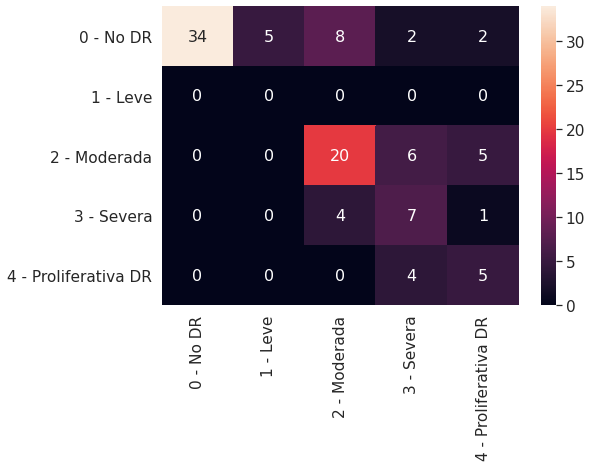

In [131]:
labels = ['0 - No DR', '1 - Leve', '2 - Moderada', '3 - Severa', '4 - Proliferativa DR']
plot_conf_matrix(ttapreds1, y_test2tta,labels)

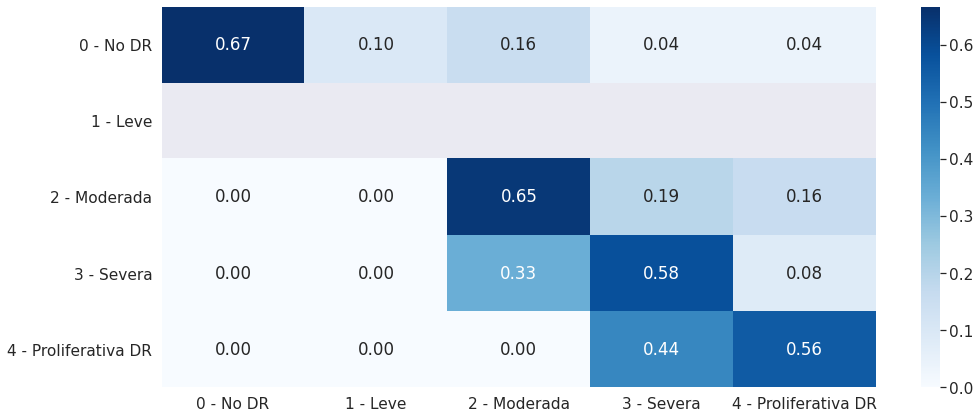

In [132]:
cnf_matrix = confusion_matrix(ttapreds1, y_test2tta)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

# TTA y trimedian

In [133]:
preds_ensemble = []


for i in range(len(model_list)):
  preds_tta = []

  test_preds_model = model_list[i].predict(x_tdata, verbose = 1)
  preds_tta.append(test_preds_model)

  test_preds_model = model_list[i].predict(x_tdata1, verbose = 1)
  preds_tta.append(test_preds_model)

  test_preds_model = model_list[i].predict(x_tdata2, verbose = 1)
  preds_tta.append(test_preds_model)

  test_preds_model = model_list[i].predict(x_tdata3, verbose = 1)
  preds_tta.append(test_preds_model)

  test_preds_model = model_list[i].predict(x_tdata4, verbose = 1)
  preds_tta.append(test_preds_model)

  test_preds_model = model_list[i].predict(x_tdata5, verbose = 1)
  preds_tta.append(test_preds_model)

  test_model = stats.trim_mean(preds_tta,0.25, axis=0)
  preds_ensemble.append(test_model)

preds1_ensemble = stats.trim_mean(preds_ensemble,0.25, axis=0)


4/4 [==============================] - 0s 53ms/step


In [134]:
preds1_ensemble1 = [np.argmax(pred) for pred in preds1_ensemble]

In [135]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(preds1_ensemble1, y_test2tta, weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(preds1_ensemble1, y_test2tta))

print('F1 score: %.3f' % f1_score(preds1_ensemble1, y_test2tta,average='micro'))
print('F1 score: %.3f' % f1_score(preds1_ensemble1, y_test2tta,average='weighted'))
print('F1 score: %.3f' % f1_score( y_test2tta,preds1_ensemble1,average='macro'))

print('Recall: %.3f' % recall_score(preds1_ensemble1, y_test2tta,average='micro'))
print('Recall: %.3f' % recall_score(y_test2tta,preds1_ensemble1,average='weighted'))
print('Recall: %.3f' % recall_score(y_test2tta,preds1_ensemble1,average='macro'))


print('Precision: %.3f' % precision_score(preds1_ensemble1, y_test2tta,average='micro'))
print('Precision: %.3f' % precision_score(preds1_ensemble1, y_test2tta,average='weighted'))
print('Precision: %.3f' % precision_score(y_test2tta, preds1_ensemble1, average='macro'))

print('\n clasification report:\n  ' + classification_report(preds1_ensemble1, y_test2tta))

Test Cohen Kappa score: 0.713
Test Accuracy score : 0.641
F1 score: 0.641
F1 score: 0.680
F1 score: 0.468
Recall: 0.641
Recall: 0.641
Recall: 0.476
Precision: 0.641
Precision: 0.760
Precision: 0.490

 clasification report:
                precision    recall  f1-score   support

           0       1.00      0.67      0.80        51
           1       0.00      0.00      0.00         0
           2       0.62      0.65      0.63        31
           3       0.37      0.58      0.45        12
           4       0.38      0.56      0.45         9

    accuracy                           0.64       103
   macro avg       0.48      0.49      0.47       103
weighted avg       0.76      0.64      0.68       103

